# Are there any UV selection effects from SDSS that can affect our comparison?

In [1]:
import numpy as np 
from astrologs.astrologs import Astrologs
import matplotlib.pyplot as plt

In [2]:
nsa = Astrologs('nsa', vagc_footprint=True)

In [4]:
abs_g, abs_r = nsa.data['ABSMAG'][:,3], nsa.data['ABSMAG'][:,4]
abs_fuv, abs_nuv = nsa.data['ABSMAG'][:,0], nsa.data['ABSMAG'][:,1]

In [5]:
petro_fuv, petro_nuv = nsa.data['PETROFLUX'][:,0], nsa.data['PETROFLUX'][:,1]
nmgy_fuv, nmgy_nuv = nsa.data['NMGY'][:,0], nsa.data['NMGY'][:,1]

In [6]:
# reconstructed nanomaggies from k-correct
rnmgy_fuv, rnmgy_nuv = nsa.data['RNMGY'][:,0], nsa.data['RNMGY'][:,1]

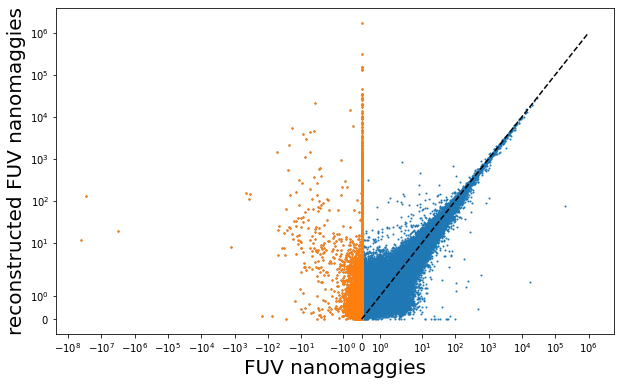

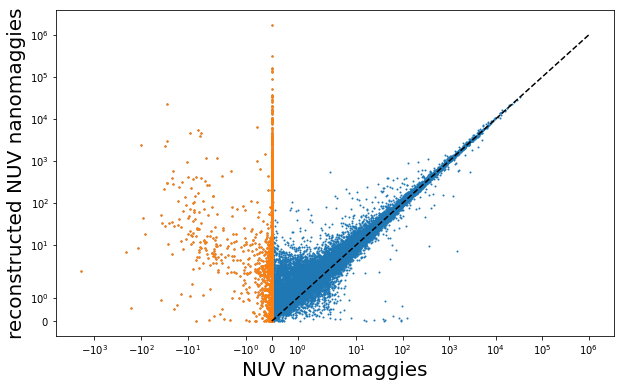

In [43]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_fuv, rnmgy_fuv, c='C0', s=1)
sub.scatter(nmgy_fuv[nmgy_fuv <= 0], rnmgy_fuv[nmgy_fuv <= 0], c='C1', s=2)
sub.plot([0, 1e6], [0, 1e6], c='k', ls='--')
sub.set_xlabel('FUV nanomaggies', fontsize=20)
sub.set_xscale('symlog')
sub.set_ylabel('reconstructed FUV nanomaggies', fontsize=20)
sub.set_yscale('symlog')

fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_nuv, rnmgy_nuv, c='C0', s=1)
sub.scatter(nmgy_nuv[nmgy_nuv <= 0], rnmgy_nuv[nmgy_nuv <= 0], c='C1', s=2)
sub.plot([0, 1e6], [0, 1e6], c='k', ls='--')
sub.set_xlabel('NUV nanomaggies', fontsize=20)
sub.set_xscale('symlog')
sub.set_ylabel('reconstructed NUV nanomaggies', fontsize=20)
sub.set_yscale('symlog')

Lets see how these UV nondetections propagate for k-corrected absolute magnitudes

Text(0, 0.5, 'FUV absolute magnitude')

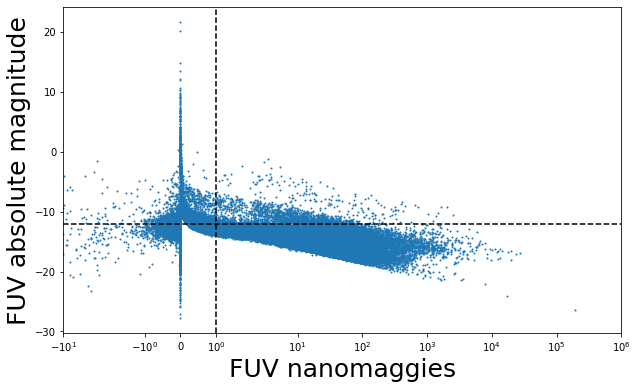

In [54]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_fuv, abs_fuv, c='C0', s=1)
sub.axhline(-12, color='k', linestyle='--')
sub.axvline(1., color='k', linestyle='--')
sub.set_xlabel('FUV nanomaggies', fontsize=25)
sub.set_xscale('symlog')
sub.set_xlim(-10, 1e6)
sub.set_ylabel('FUV absolute magnitude', fontsize=25)

Text(0, 0.5, 'NUV absolute magnitude')

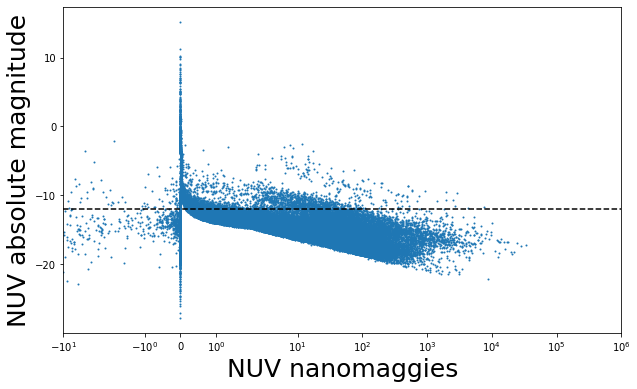

In [11]:
fig = plt.figure(figsize=(10,6))
sub = fig.add_subplot(111)
sub.scatter(nmgy_nuv, abs_nuv, c='C0', s=1)
sub.axhline(-12, color='k', linestyle='--')
sub.set_xlabel('NUV nanomaggies', fontsize=25)
sub.set_xscale('symlog')
sub.set_xlim(-10, 1e6)
sub.set_ylabel('NUV absolute magnitude', fontsize=25)

(array([  3.,  13.,  47., 345., 661., 120.,  44.,  16.,   6.,   2.]),
 array([-23.297354 , -21.178507 , -19.05966  , -16.940813 , -14.821966 ,
        -12.703119 , -10.584272 ,  -8.4654255,  -6.3465786,  -4.2277317,
         -2.1088848], dtype=float32),
 <a list of 10 Patch objects>)

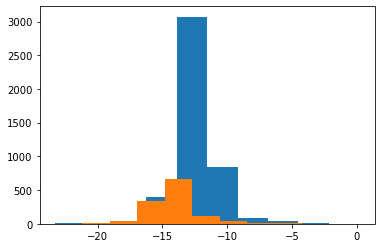

In [33]:
plt.hist(abs_fuv[nmgy_fuv < 0])
plt.hist(abs_nuv[nmgy_nuv < 0])

(-30.0, 10.0)

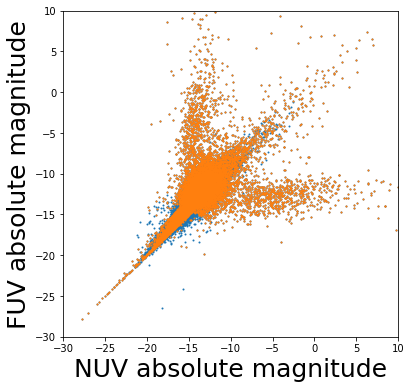

In [45]:
fig = plt.figure(figsize=(6,6))
sub = fig.add_subplot(111)
sub.scatter(abs_nuv, abs_fuv, c='C0', s=1)
sub.scatter(abs_nuv[(nmgy_nuv < 1) | (nmgy_fuv < 1)], abs_fuv[(nmgy_nuv < 1) | (nmgy_fuv < 1)], c='C1', s=1)
sub.set_xlabel('NUV absolute magnitude', fontsize=25)
sub.set_ylabel('FUV absolute magnitude', fontsize=25)
sub.set_xlim([-30., 10])
sub.set_ylim([-30., 10])

In [13]:
from galpopfm import dustfm as dustFM
from galpopfm import dust_infer as dustInfer
from galpopfm import measure_obs as measureObs


def fm(sim, theta): 
    _sim_sed = dustInfer._read_sed(sim) 
    wlim = (_sim_sed['wave'] > 1e3) & (_sim_sed['wave'] < 8e3) 

    mlim    = np.ones(len(_sim_sed['logmstar'])).astype(bool)#(_sim_sed['logmstar'] > 9.4) 
    zerosfr = (_sim_sed['logsfr.inst'] == -999)
    cuts    = mlim 

    sim_sed = {} 
    sim_sed['sim']          = sim 
    sim_sed['logmstar']     = _sim_sed['logmstar'][cuts].copy()
    sim_sed['logsfr.inst']  = _sim_sed['logsfr.inst'][cuts].copy() 
    sim_sed['wave']         = _sim_sed['wave'][wlim].copy()
    sim_sed['sed_noneb']    = _sim_sed['sed_noneb'][cuts,:][:,wlim].copy() 
    sim_sed['sed_onlyneb']  = _sim_sed['sed_onlyneb'][cuts,:][:,wlim].copy() 
    
    sed_dusty = dustFM.Attenuate(
        theta, 
        sim_sed['wave'], 
        sim_sed['sed_noneb'], 
        sim_sed['sed_onlyneb'], 
        sim_sed['logmstar'],
        sim_sed['logsfr.inst'],
        dem='slab_noll_mssfr_fixbump') 
    
    # observational measurements 
    F_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_fuv') 
    N_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='galex_nuv') 
    G_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='g_sdss') 
    R_mag = measureObs.AbsMag_sed(sim_sed['wave'], sed_dusty, band='r_sdss') 

    return F_mag, N_mag, G_mag, R_mag

In [14]:
F_eag, N_eag, G_eag, R_eag = fm('eagle', np.zeros(6))
F_tng, N_tng, G_tng, R_tng = fm('tng', np.zeros(6))
F_sim, N_sim, G_sim, R_sim = fm('simba', np.zeros(6))

Text(0.5, 1.0, 'SIMBA')

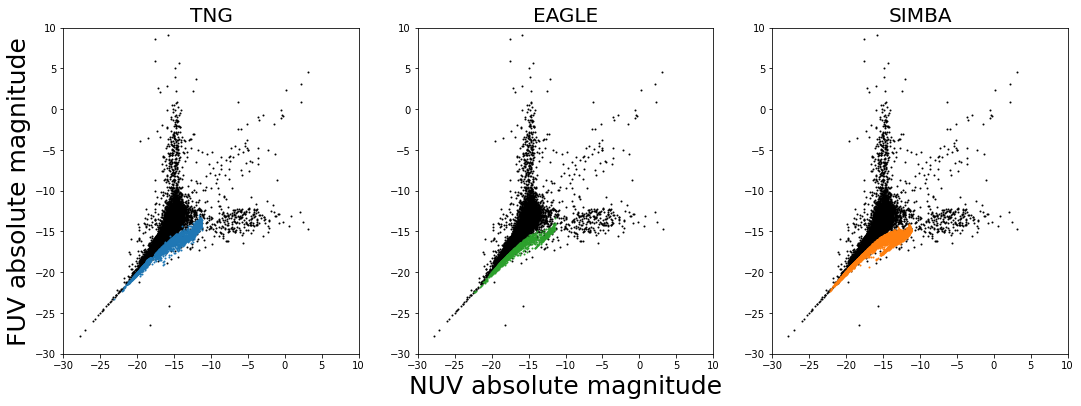

In [17]:
fig = plt.figure(figsize=(18,6))
sub = fig.add_subplot(1,3,1)
sub.scatter(abs_nuv[abs_r < -20], abs_fuv[abs_r < -20], c='k', s=1)
sub.scatter(F_tng[R_tng < -20], N_tng[R_tng < -20], c='C0', s=1)
sub.set_ylabel('FUV absolute magnitude', fontsize=25)
sub.set_xlim([-30., 10])
sub.set_ylim([-30., 10])
sub.set_title('TNG', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(abs_nuv[abs_r < -20], abs_fuv[abs_r < -20], c='k', s=1)
sub.scatter(F_eag[R_eag < -20], N_eag[R_eag < -20], c='C2', s=1)
sub.set_xlabel('NUV absolute magnitude', fontsize=25)
sub.set_xlim([-30., 10])
sub.set_ylim([-30., 10])
sub.set_title('EAGLE', fontsize=20)

sub = fig.add_subplot(133)
sub.scatter(abs_nuv[abs_r < -20], abs_fuv[abs_r < -20], c='k', s=1)
sub.scatter(F_sim[R_sim < -20], N_sim[R_sim < -20], c='C1', s=1)
sub.set_xlim([-30., 10])
sub.set_ylim([-30., 10])
sub.set_title('SIMBA', fontsize=20)

Text(0.5, 1.0, 'SIMBA (no dust)')

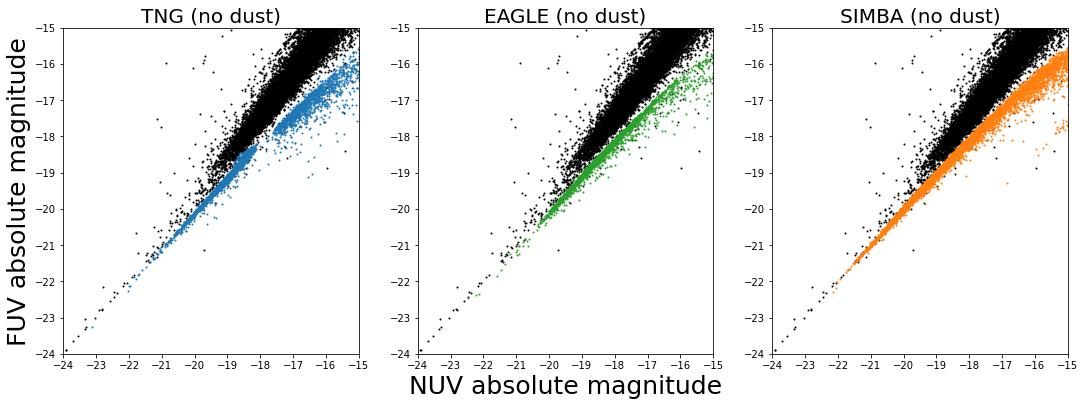

In [34]:
fig = plt.figure(figsize=(18,6))
sub = fig.add_subplot(1,3,1)
sub.scatter(abs_nuv[abs_r < -20], abs_fuv[abs_r < -20], c='k', s=1)
sub.scatter(F_tng[R_tng < -20], N_tng[R_tng < -20], c='C0', s=1)
sub.set_ylabel('FUV absolute magnitude', fontsize=25)
sub.set_xlim([-24., -15])
sub.set_ylim([-24., -15])
sub.set_title('TNG (no dust)', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter(abs_nuv[abs_r < -20], abs_fuv[abs_r < -20], c='k', s=1)
sub.scatter(F_eag[R_eag < -20], N_eag[R_eag < -20], c='C2', s=1)
sub.set_xlabel('NUV absolute magnitude', fontsize=25)
sub.set_xlim([-24., -15])
sub.set_ylim([-24., -15])
sub.set_title('EAGLE (no dust)', fontsize=20)

sub = fig.add_subplot(133)
sub.scatter(abs_nuv[abs_r < -20], abs_fuv[abs_r < -20], c='k', s=1)
sub.scatter(F_sim[R_sim < -20], N_sim[R_sim < -20], c='C1', s=1)
sub.set_xlim([-24., -15])
sub.set_ylim([-24., -15])
sub.set_title('SIMBA (no dust)', fontsize=20)

Text(0.5, 1.0, 'SIMBA (no dust)')

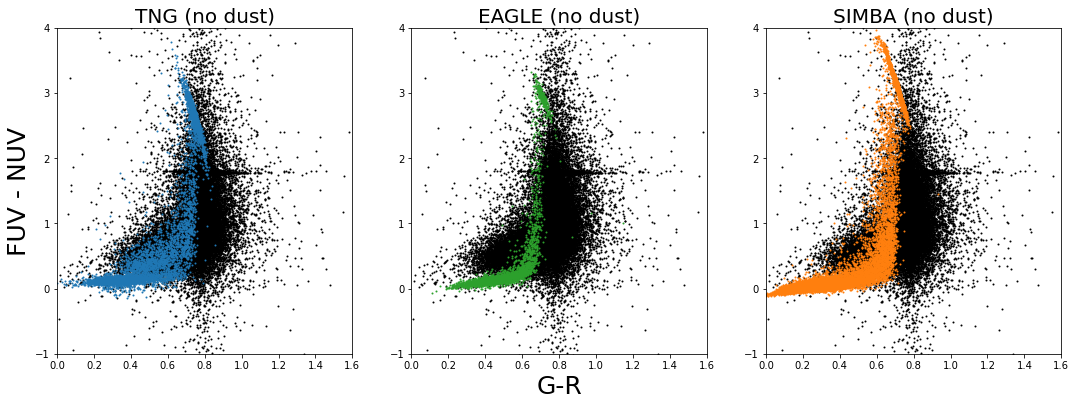

In [28]:
fig = plt.figure(figsize=(18,6))
sub = fig.add_subplot(1,3,1)
sub.scatter((abs_g - abs_r)[(abs_r < -20)], (abs_fuv - abs_nuv)[(abs_r < -20)], c='k', s=1)
sub.scatter((G_tng - R_tng)[(R_tng < -20)], (F_tng - N_tng)[(R_tng < -20)], c='C0', s=1)
sub.set_ylabel('FUV - NUV', fontsize=25)
sub.set_xlim(0., 1.6)
sub.set_ylim(-1., 4)
sub.set_title('TNG (no dust)', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter((abs_g - abs_r)[(abs_r < -20)], (abs_fuv - abs_nuv)[(abs_r < -20)], c='k', s=1)
sub.scatter((G_eag - R_eag)[(R_eag < -20)], (F_eag - N_eag)[(R_eag < -20)], c='C2', s=1)
sub.set_xlabel('G-R', fontsize=25)
sub.set_xlim(0., 1.6)
sub.set_ylim(-1., 4)
sub.set_title('EAGLE (no dust)', fontsize=20)

sub = fig.add_subplot(133)
sub.scatter((abs_g - abs_r)[(abs_r < -20)], (abs_fuv - abs_nuv)[(abs_r < -20)], c='k', s=1)
sub.scatter((G_sim - R_sim)[(R_sim < -20)], (F_sim - N_sim)[(R_sim < -20)], c='C1', s=1)
sub.set_xlim(0., 1.6)
sub.set_ylim(-1., 4)
sub.set_title('SIMBA (no dust)', fontsize=20)

Text(0.5, 1.0, 'SIMBA (no dust)')

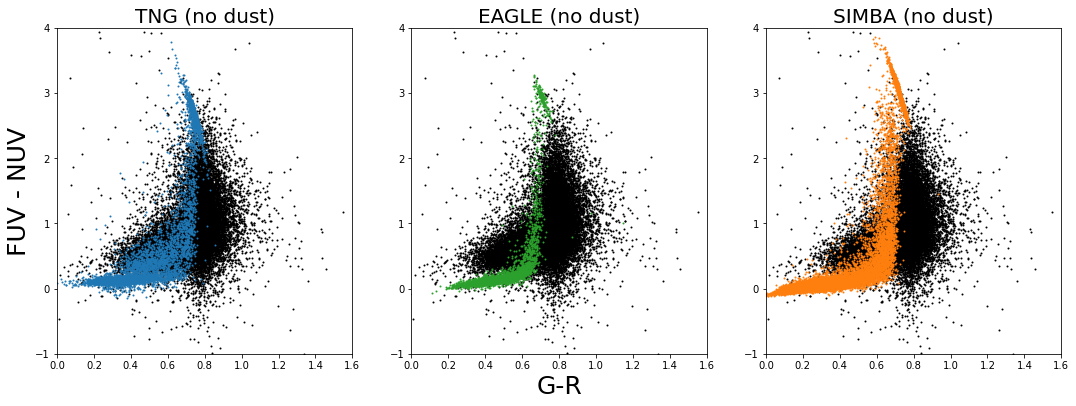

In [55]:
uv_cut = -12
fig = plt.figure(figsize=(18,6))
sub = fig.add_subplot(1,3,1)
sub.scatter((abs_g - abs_r)[(abs_r < -20) & (abs_fuv < uv_cut) & (abs_nuv < uv_cut) & ~((nmgy_nuv < 1) | (nmgy_fuv < 1))], 
            (abs_fuv - abs_nuv)[(abs_r < -20) & (abs_fuv < uv_cut) & (abs_nuv < uv_cut) & ~((nmgy_nuv < 1) | (nmgy_fuv < 1))], c='k', s=1)
sub.scatter((G_tng - R_tng)[(R_tng < -20) & (F_tng < uv_cut) & (N_tng < uv_cut)], 
            (F_tng - N_tng)[(R_tng < -20) & (F_tng < uv_cut) & (N_tng < uv_cut)], c='C0', s=1)
sub.set_ylabel('FUV - NUV', fontsize=25)
sub.set_xlim(0., 1.6)
sub.set_ylim(-1., 4)
sub.set_title('TNG (no dust)', fontsize=20)

sub = fig.add_subplot(132)
sub.scatter((abs_g - abs_r)[(abs_r < -20) & (abs_fuv < uv_cut) & (abs_nuv < uv_cut) & ~((nmgy_nuv < 1) | (nmgy_fuv < 1))], 
            (abs_fuv - abs_nuv)[(abs_r < -20) & (abs_fuv < uv_cut) & (abs_nuv < uv_cut) & ~((nmgy_nuv < 1) | (nmgy_fuv < 1))], c='k', s=1)
sub.scatter((G_eag - R_eag)[(R_eag < -20) & (F_eag < uv_cut) & (N_eag < uv_cut)], 
            (F_eag - N_eag)[(R_eag < -20) & (F_eag < uv_cut) & (N_eag < uv_cut)], c='C2', s=1)
sub.set_xlabel('G-R', fontsize=25)
sub.set_xlim(0., 1.6)
sub.set_ylim(-1., 4)
sub.set_title('EAGLE (no dust)', fontsize=20)

sub = fig.add_subplot(133)
sub.scatter((abs_g - abs_r)[(abs_r < -20) & (abs_fuv < uv_cut) & (abs_nuv < uv_cut) & ~((nmgy_nuv < 1) | (nmgy_fuv < 1))], 
            (abs_fuv - abs_nuv)[(abs_r < -20) & (abs_fuv < uv_cut) & (abs_nuv < uv_cut) & ~((nmgy_nuv < 1) | (nmgy_fuv < 1))], c='k', s=1)
sub.scatter((G_sim - R_sim)[(R_sim < -20) & (F_sim < uv_cut) & (N_sim < uv_cut)], 
            (F_sim - N_sim)[(R_sim < -20) & (F_sim < uv_cut) & (N_sim < uv_cut)], c='C1', s=1)
sub.set_xlim(0., 1.6)
sub.set_ylim(-1., 4)
sub.set_title('SIMBA (no dust)', fontsize=20)